In [60]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from scipy import signal
import os
from datetime import datetime, timedelta
import re

In [61]:
experiment_raw_df = {}

## Import Mistras (AE Sensor) Hits Dataframe

In [62]:
skip_mistras_import = False
Mistras_filepath = ""
while True:
    # Specify the file path directly
    filename = input("Please enter the name of your Mistras .txt file (Enter 'None' to skip Mistras import): ")
    if filename.strip().lower() == 'none':
        skip_mistras_import = True
        break
    folder = input("Please enter the full path (not including the filename) to your .txt file: ")

    if folder:
        Mistras_filepath = folder + "\\" + filename
    else: 
        Mistras_filepath = filename

    print("\nMistras Data Filepath: ", Mistras_filepath)

    if os.path.isfile(Mistras_filepath):
        break
    print("\nThe specified file does not exist. Please check the path and try again.")


Mistras Data Filepath:  C:\Users\sapierso\Documents\AE Data\PD-acoustic90\PD-acoustic90_hits.txt


In [63]:
def get_mistras_metadata(filepath, df):
    metadata = {}
    
    # This regex pattern matches a time format and optionally captures microseconds if present
    time_pattern = re.compile(r'\b(\d{2}:\d{2}:\d{2})(?:\.(\d+))?\b')
    
    with open(filepath, 'r') as file:
        for line in file:
            match = re.search(time_pattern, line)
            if match:
                time_str = match.group(1)  # Time in HH:MM:SS
                microseconds_str = match.group(2) if match.group(2) else '000000'  # Microseconds part if present, else '0'
                break
        else:
            # Handle case where no time is found
            return None

    # Append microseconds to the time string and parse
    full_time_str = f"{time_str}.{microseconds_str}"
    time_obj = datetime.strptime(full_time_str, "%H:%M:%S.%f")

    metadata['start_time'] = time_obj
    metadata['duration'] = df['SSSSSSSS.mmmuuun'].iloc[-1]
    return metadata

def import_mistras_file_to_df(filepath):
    # Read the data using read_csv, assuming tab-separated values (TSV); adjust delimiter if needed
    df = pd.read_csv(filepath, delim_whitespace=True, header=4)
    # There is a bad import on the 'SIG STRNGTH col because it has a space in the name and the file is whitespace-delimted
    column_names_AE_Node = [
        'ID', 'SSSSSSSS.mmmuuun', 'CH', 'RISE', 'COUN', 'ENER', 
        'DURATION', 'AMP', 'A-FRQ', 'RMS', 'ASL', 'PCNTS', 'THR', 'R-FRQ', 
        'I-FRQ', 'SIG STRNGTH', 'ABS-ENERGY'
    ]
    column_names_EasyAE = [
        'ID', 'SSSSSSSS.mmmuuun', 'PARA1', 'RISE', 'COUN', 'ENER', 
        'DURATION', 'A-FRQ', 'RMS', 'PCNTS', 'THR', 'R-FRQ', 
        'I-FRQ', 'SIG STRNGTH', 'ABS-ENERGY', 'FRQ-C', 'P-FRQ', 'AMP', 'ASL'
    ]
    column_names = column_names_EasyAE
    # Keep all columns except the last one
    df = df.iloc[:, :-1]
    df.columns = column_names
    return df

def process_mistras_df(df, metadata):
    # Drop 'ID' col
    df = df.drop('ID', axis=1)
    # Rename time col
    df.rename(columns={'SSSSSSSS.mmmuuun': 'TIME'}, inplace=True)
    
    # Add 'Absolute time' column to the data
    mistras_start_time_obj = metadata['start_time']
    seconds = df['TIME']
    time_deltas = pd.to_timedelta(seconds, unit='s')
    absolute_time = mistras_start_time_obj + time_deltas
    df.insert(0, 'Absolute Time', absolute_time)
    
    return df

if not skip_mistras_import:
    mistras_df = import_mistras_file_to_df(Mistras_filepath)
    mistras_metadata = get_mistras_metadata(Mistras_filepath, mistras_df)
    mistras_df = process_mistras_df(mistras_df, mistras_metadata)
    print("Start time:", mistras_metadata['start_time'])
    print("Duration: " + str(mistras_metadata['duration']) + " s")

    experiment_raw_df['mistras_df'] = {'metadata': mistras_metadata, 'df': mistras_df}

    display(mistras_df)

C:\Users\sapierso\AppData\Local\Temp\ipykernel_4008\2224814454.py:28: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filepath, delim_whitespace=True, header=4)


Start time: 1900-01-01 12:37:10
Duration: 63.7361448 s


,Absolute Time,TIME,PARA1,RISE,COUN,ENER,DURATION,A-FRQ,RMS,PCNTS,THR,R-FRQ,I-FRQ,SIG STRNGTH,ABS-ENERGY,FRQ-C,P-FRQ,AMP,ASL
0,1900-01-01 12:37:10.000007800,0.000008,0.0177,220,34,0,1001,34,0.0,9,10,32,40,692.35,0.472017,206,0,17.6,9.4
1,1900-01-01 12:37:10.002030800,0.002031,0.0182,495,38,0,989,38,0.0,18,10,40,36,674.05,0.450604,212,0,17.6,9.4
2,1900-01-01 12:37:10.004031500,0.004032,0.0180,242,40,0,1000,40,0.0,9,10,40,37,692.35,0.485982,207,0,18.4,9.4
3,1900-01-01 12:37:10.006043700,0.006044,0.0177,128,35,0,999,35,0.0,6,10,33,46,497.15,0.352849,211,0,17.6,9.4
4,1900-01-01 12:37:10.008125700,0.008126,0.0177,959,34,0,999,34,0.0,33,10,25,34,683.20,0.458983,211,0,17.6,9.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31508,1900-01-01 12:38:13.728000700,63.728001,0.0182,883,37,0,991,37,0.0,31,10,55,35,646.60,0.447811,191,0,18.4,9.4
31509,1900-01-01 12:38:13.730116800,63.730117,0.0180,383,34,0,1001,34,0.0,12,10,35,31,701.50,0.486913,195,0,18.4,9.4
31510,1900-01-01 12:38:13.732117500,63.732118,0.0179,846,36,0,1001,36,0.0,31,10,32,36,619.15,0.414295,195,0,16.7,9.4
31511,1900-01-01 12:38:13.734118800,63.734119,0.0177,499,34,0,1000,34,0.0,17,10,33,34,628.30,0.427329,193,0,18.4,9.4


## Import Mistras (AE Sensor) Time-Driven Data Dataframe

In [64]:
skip_mistras_tdd_import = False
Mistras_tdd_filepath = ""
while True:
    # Specify the file path directly
    filename = input("Please enter the name of your Mistras TDD .txt file (Enter 'None' to skip import): ")
    if filename.strip().lower() == 'none':
        skip_mistras_tdd_import = True
        break
    folder = input("Please enter the full path (not including the filename) to your .txt file: ")

    if folder:
        Mistras_tdd_filepath = folder + "\\" + filename
    else: 
        Mistras_tdd_filepath = filename

    print("\nMistras TDD Data Filepath: ", Mistras_tdd_filepath)

    if os.path.isfile(Mistras_tdd_filepath):
        break
    print("\nThe specified file does not exist. Please check the path and try again.")


Mistras TDD Data Filepath:  C:\Users\sapierso\Documents\AE Data\PD-acoustic90\PD-acoustic90_time.txt


In [65]:
def parse_tdd_data(file_path):
    # Initialize lists to store data
    timestamps = []
    rms = []
    asl = []
    thr = []
    abs_energy = []
    
    # Open and read the file
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('  2 '):
                # Extract timestamp
                timestamp = float(line.split()[-1])
                timestamps.append(timestamp)
                
                # Read the next two lines
                _ = next(file)  # Skip the "CH:[    RMS ASL THR  ABS-ENERGY]" line
                channel_data = next(file).strip()
                
                # Extract channel data
                data = channel_data.split('[')[-1].split(']')[0].split()
                rms.append(float(data[0]))
                asl.append(int(data[1]))
                thr.append(float(data[2]))
                abs_energy.append(float(data[3]))
    
    # Create DataFrame
    df = pd.DataFrame({
        'SSSSSSSS.mmmuuun': timestamps,
        'RMS_CONTINUOUS': rms,
        'ASL_CONTINUOUS': asl,
        'THR_CONTINUOUS': thr,
        'ABS_ENERGY_CONTINUOUS': abs_energy
    })
    
    return df

def process_mistras_tdd_df(df, metadata):
    # Rename time col
    df.rename(columns={'SSSSSSSS.mmmuuun': 'TIME'}, inplace=True)
    
    # Add 'Absolute time' column to the data
    mistras_start_time_obj = metadata['start_time']
    seconds = df['TIME']
    time_deltas = pd.to_timedelta(seconds, unit='s')
    absolute_time = mistras_start_time_obj + time_deltas
    df.insert(0, 'Absolute Time', absolute_time)
    
    return df

mistras_tdd_df = None
if not skip_mistras_tdd_import:
    mistras_tdd_df = parse_tdd_data(Mistras_tdd_filepath)
    mistras_tdd_metadata = get_mistras_metadata(Mistras_tdd_filepath, mistras_tdd_df)
    mistras_tdd_df = process_mistras_tdd_df(mistras_tdd_df, mistras_tdd_metadata)
    print("Start time:", mistras_tdd_metadata['start_time'])
    print("Duration: " + str(mistras_tdd_metadata['duration']) + " s")
    experiment_raw_df['mistras_tdd_df'] = {'metadata': mistras_tdd_metadata, 'df': mistras_tdd_df}
    display(mistras_tdd_df)

Start time: 1900-01-01 12:37:10
Duration: 0.018 s


,Absolute Time,TIME,RMS_CONTINUOUS,ASL_CONTINUOUS,THR_CONTINUOUS,ABS_ENERGY_CONTINUOUS
0,1900-01-01 12:37:10.018200,0.0182,0.0,10,0.000,0.1
1,1900-01-01 12:37:10.018300,0.0183,0.0,10,4.276,6.3
2,1900-01-01 12:37:10.017900,0.0179,0.0,10,4.386,7.6
3,1900-01-01 12:37:10.018300,0.0183,0.0,10,4.308,8.1
4,1900-01-01 12:37:10.018000,0.0180,0.0,10,4.410,8.4
...,...,...,...,...,...,...
6368,1900-01-01 12:37:10.017900,0.0179,0.0,10,4.651,9.4
6369,1900-01-01 12:37:10.018200,0.0182,0.0,10,4.289,9.4
6370,1900-01-01 12:37:10.017900,0.0179,0.0,10,4.051,9.4
6371,1900-01-01 12:37:10.017900,0.0179,0.0,10,4.323,9.4


## Import Two-Phase Times CSV
### Done manually and should have the following format:
Start Time,End Time</br>
212.8,213.8</br>
214.9,215.3</br>
...</br>


In [66]:
skip_two_phase_times_import = False
TwoPhaseTimes_filepath = ""
while True:
    # Specify the filepath directly
    filename = input("Please enter the name of your Two Phase Times .csv file (Enter 'None' to skip import): ")
    if filename.strip().lower() == 'none':
        skip_two_phase_times_import = True
        break
    folder = input("Please enter the full path (not including the filename) to your .csv file: ")

    if folder:
        TwoPhaseTimes_filepath = folder + "\\" + filename
    else: 
        TwoPhaseTimes_filepath = filename

    print("\nTwo Phase Times csv Filepath: ", TwoPhaseTimes_filepath)

    if os.path.isfile(TwoPhaseTimes_filepath):
        break
    print("\nThe specified file does not exist. Please check the path and try again.")

two_phase_spans = None
if not skip_two_phase_times_import:
    two_phase_times_df = pd.read_csv(TwoPhaseTimes_filepath)
    column_names = two_phase_times_df.columns[:2]
    two_phase_spans = two_phase_times_df[column_names].values.tolist()
    display(two_phase_spans)

## Process/Merge Data

In [67]:
class ArgumentConflict(Exception):
    def __init__(self, message="The arguments in this function overdefine the method"):
        self.message = message
        super().__init__(self.message)

# Post-process the merged dataset to calculate the # of hits
def count_ae_hits(df, n_bins=None, time_delta=None):
    if n_bins is not None and time_delta is not None:
        raise ArgumentConflict
    elif time_delta is not None and n_bins is None:
        n_bins = math.floor(df['TIME'].max() / time_delta)
    elif n_bins is not None and time_delta is None:
        time_delta = df['TIME'].max() / n_bins
    n_hits = []
    for start_time in range(0, math.floor(df['TIME'].max())-1, time_delta):
        end_time = start_time + time_delta
        # Selecting the subsection
        subsection = df[(df['TIME'] >= start_time) & (df['TIME'] < end_time)]
        # Count non-NaN entries in the 'Data' column
        count_non_nan = subsection['RISE'].notna().sum()
        n_hits.append(count_non_nan)
        # print(f"Time from {start_time} to {end_time} seconds: {count_non_nan} non-NaN values")
    hits = np.array(n_hits).astype(float)
    increments = np.arange(time_delta, time_delta * (n_bins), time_delta).astype(float)
    hits_df = pd.DataFrame({
        'TIME': increments,
        'Hits': hits
    })
    return hits_df


hits = count_ae_hits(mistras_df, time_delta=1)
mistras_df = pd.merge_asof(left=mistras_df, right=hits, on='TIME', direction='backward')

In [68]:
display(mistras_df)

,Absolute Time,TIME,PARA1,RISE,COUN,ENER,DURATION,A-FRQ,RMS,PCNTS,THR,R-FRQ,I-FRQ,SIG STRNGTH,ABS-ENERGY,FRQ-C,P-FRQ,AMP,ASL,Hits
0,1900-01-01 12:37:10.000007800,0.000008,0.0177,220,34,0,1001,34,0.0,9,10,32,40,692.35,0.472017,206,0,17.6,9.4,NaN
1,1900-01-01 12:37:10.002030800,0.002031,0.0182,495,38,0,989,38,0.0,18,10,40,36,674.05,0.450604,212,0,17.6,9.4,NaN
2,1900-01-01 12:37:10.004031500,0.004032,0.0180,242,40,0,1000,40,0.0,9,10,40,37,692.35,0.485982,207,0,18.4,9.4,NaN
3,1900-01-01 12:37:10.006043700,0.006044,0.0177,128,35,0,999,35,0.0,6,10,33,46,497.15,0.352849,211,0,17.6,9.4,NaN
4,1900-01-01 12:37:10.008125700,0.008126,0.0177,959,34,0,999,34,0.0,33,10,25,34,683.20,0.458983,211,0,17.6,9.4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31508,1900-01-01 12:38:13.728000700,63.728001,0.0182,883,37,0,991,37,0.0,31,10,55,35,646.60,0.447811,191,0,18.4,9.4,495.0
31509,1900-01-01 12:38:13.730116800,63.730117,0.0180,383,34,0,1001,34,0.0,12,10,35,31,701.50,0.486913,195,0,18.4,9.4,495.0
31510,1900-01-01 12:38:13.732117500,63.732118,0.0179,846,36,0,1001,36,0.0,31,10,32,36,619.15,0.414295,195,0,16.7,9.4,495.0
31511,1900-01-01 12:38:13.734118800,63.734119,0.0177,499,34,0,1000,34,0.0,17,10,33,34,628.30,0.427329,193,0,18.4,9.4,495.0


In [69]:
display(mistras_tdd_df)

,Absolute Time,TIME,RMS_CONTINUOUS,ASL_CONTINUOUS,THR_CONTINUOUS,ABS_ENERGY_CONTINUOUS
0,1900-01-01 12:37:10.018200,0.0182,0.0,10,0.000,0.1
1,1900-01-01 12:37:10.018300,0.0183,0.0,10,4.276,6.3
2,1900-01-01 12:37:10.017900,0.0179,0.0,10,4.386,7.6
3,1900-01-01 12:37:10.018300,0.0183,0.0,10,4.308,8.1
4,1900-01-01 12:37:10.018000,0.0180,0.0,10,4.410,8.4
...,...,...,...,...,...,...
6368,1900-01-01 12:37:10.017900,0.0179,0.0,10,4.651,9.4
6369,1900-01-01 12:37:10.018200,0.0182,0.0,10,4.289,9.4
6370,1900-01-01 12:37:10.017900,0.0179,0.0,10,4.051,9.4
6371,1900-01-01 12:37:10.017900,0.0179,0.0,10,4.323,9.4


#### Plotting AE parameters

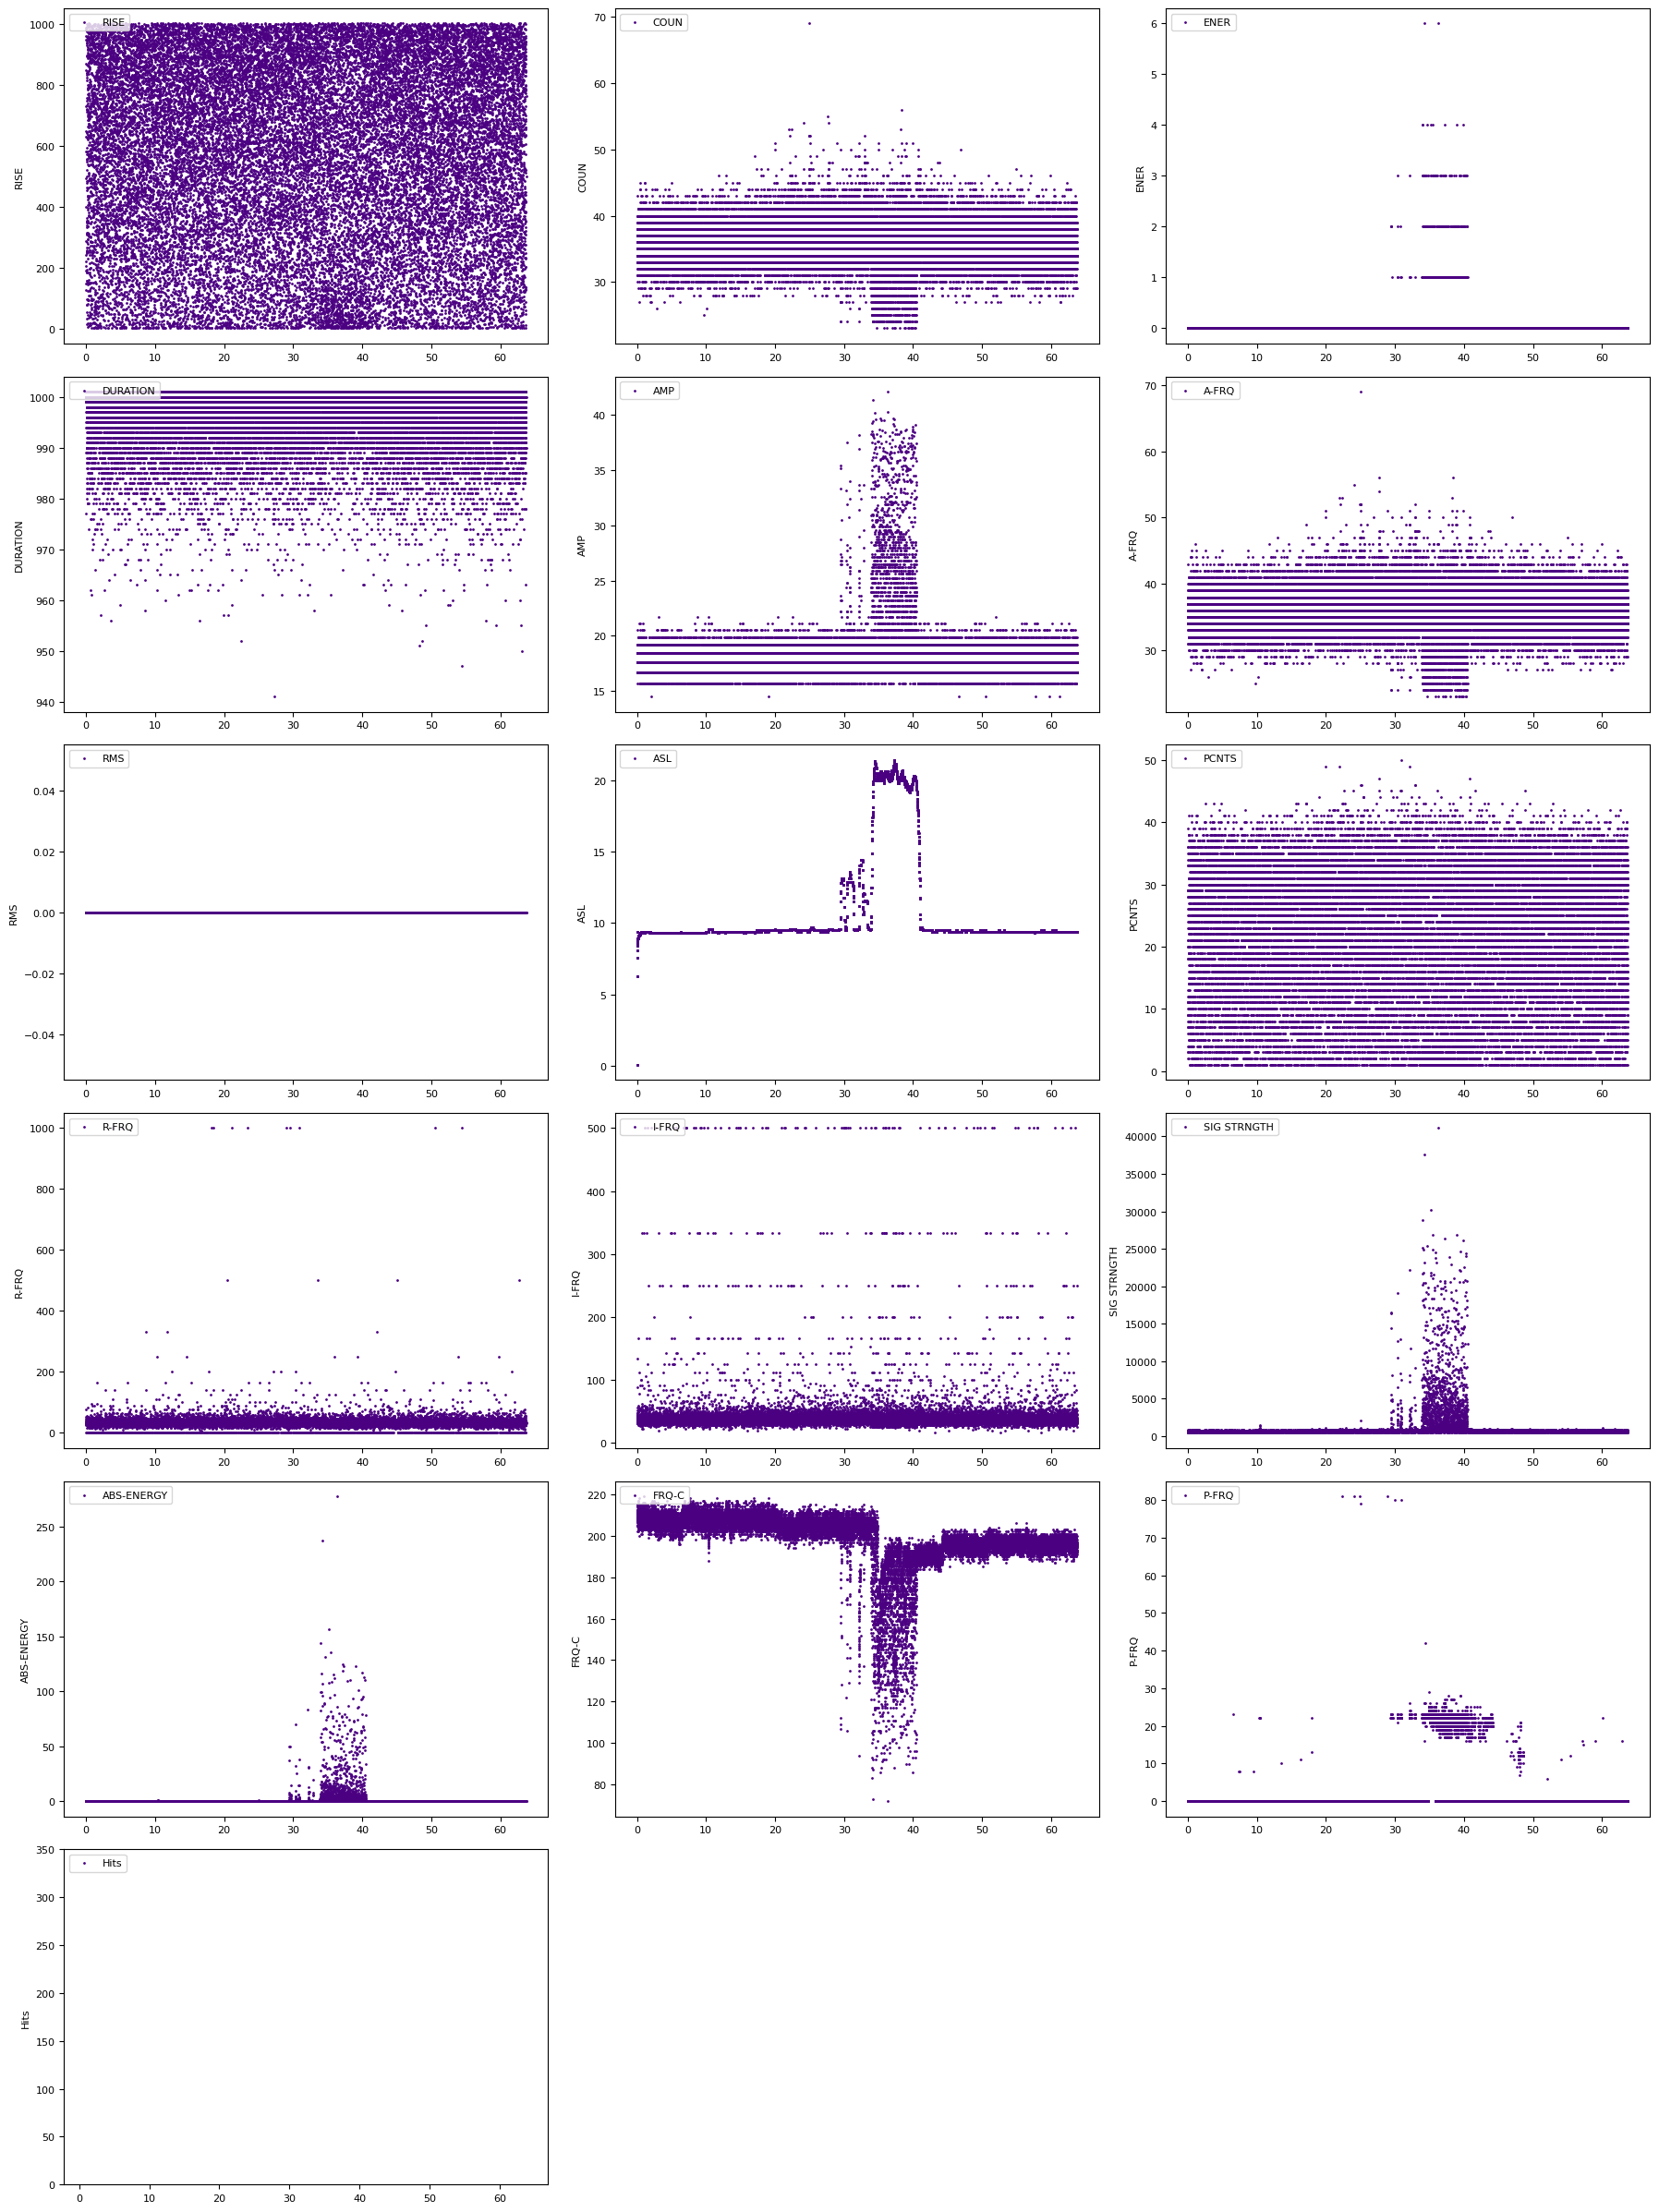

In [70]:
AE_feature_names = ["RISE", "COUN", "ENER", "DURATION", "AMP", "A-FRQ", "RMS", "ASL", "PCNTS", "R-FRQ", "I-FRQ", "SIG STRNGTH", "ABS-ENERGY", 'FRQ-C', 'P-FRQ', "Hits"]
AE_features_to_plot = []
for AE_feature_name in AE_feature_names:
    if AE_feature_name in mistras_df.columns:
        AE_features_to_plot.append({"name": AE_feature_name, "plot_type": "scatter"})

def plot_AE_features(mistras_df, AE_features_to_plot, trigger_delay=1.0, time_range=None, two_phase_spans=None):
    """
    Plot AE features with optional time range filtering
    
    Parameters:
        mistras_df (pd.DataFrame): DataFrame containing the AE data
        AE_features_to_plot (list): List of features to plot
        trigger_delay (float): Trigger delay value
        time_range (tuple): Optional (start_time, end_time) in seconds. If None, plots all data
        two_phase_spans (list): Optional list of two-phase span tuples
    """
    num_subplots = len(AE_features_to_plot)
    columns = 3
    rows = math.ceil(num_subplots / columns)
    mpl.rcParams['font.size'] = 8

    # Create a figure with a specified size
    fig = plt.figure(figsize=(18, rows * 4))
    
    # Create a GridSpec with specified height and width ratios
    gs = gridspec.GridSpec(rows, columns, height_ratios=[1]*rows, width_ratios=[1]*columns)
    
    # Filter data based on time_range if provided
    plot_df = mistras_df
    if time_range is not None:
        start_time, end_time = time_range
        plot_df = mistras_df[(mistras_df['TIME'] >= start_time) & 
                            (mistras_df['TIME'] <= end_time)].copy()

    # Create subplots using the GridSpec
    axs = []
    for r in range(rows):
        for c in range(columns):
            if len(axs) < num_subplots:
                axs.append(fig.add_subplot(gs[r, c]))

    for i, ax in enumerate(axs):
        if i < num_subplots:        
            # Plot the AE feature
            feature_to_plot = AE_features_to_plot[i]['name']
            plot_type = AE_features_to_plot[i]['plot_type']

            if plot_type == 'scatter':
                AE_plot = ax.scatter(plot_df['TIME'], plot_df[feature_to_plot], 
                                   color='indigo', label=feature_to_plot, s=1)
            elif plot_type == 'line':
                AE_plot, = ax.plot(plot_df['TIME'], plot_df[feature_to_plot], 
                                 color='indigo', label=feature_to_plot)

            if feature_to_plot == 'Hits':
                ax.set_ylim([0, 350])

            ax.set_ylabel(feature_to_plot)
            lines = [AE_plot]
            labels = [line.get_label() for line in lines]
            ax.legend(lines, labels, loc='upper left')
            
            # Set x-axis limits if time_range is provided
            if time_range is not None:
                ax.set_xlim(time_range)
            
            if two_phase_spans:
                for two_phase_span in two_phase_spans:
                    ax.axvspan(two_phase_span[0]-trigger_delay, 
                             two_phase_span[1]-trigger_delay, 
                             color='red', alpha=0.2)
        else:
            # Hide unused subplots
            ax.set_visible(False)

    plt.tight_layout()
    plt.show()

# Plot all data (default behavior)
plot_AE_features(
    mistras_df, 
    AE_features_to_plot, 
    # time_range=(0, 40)
)

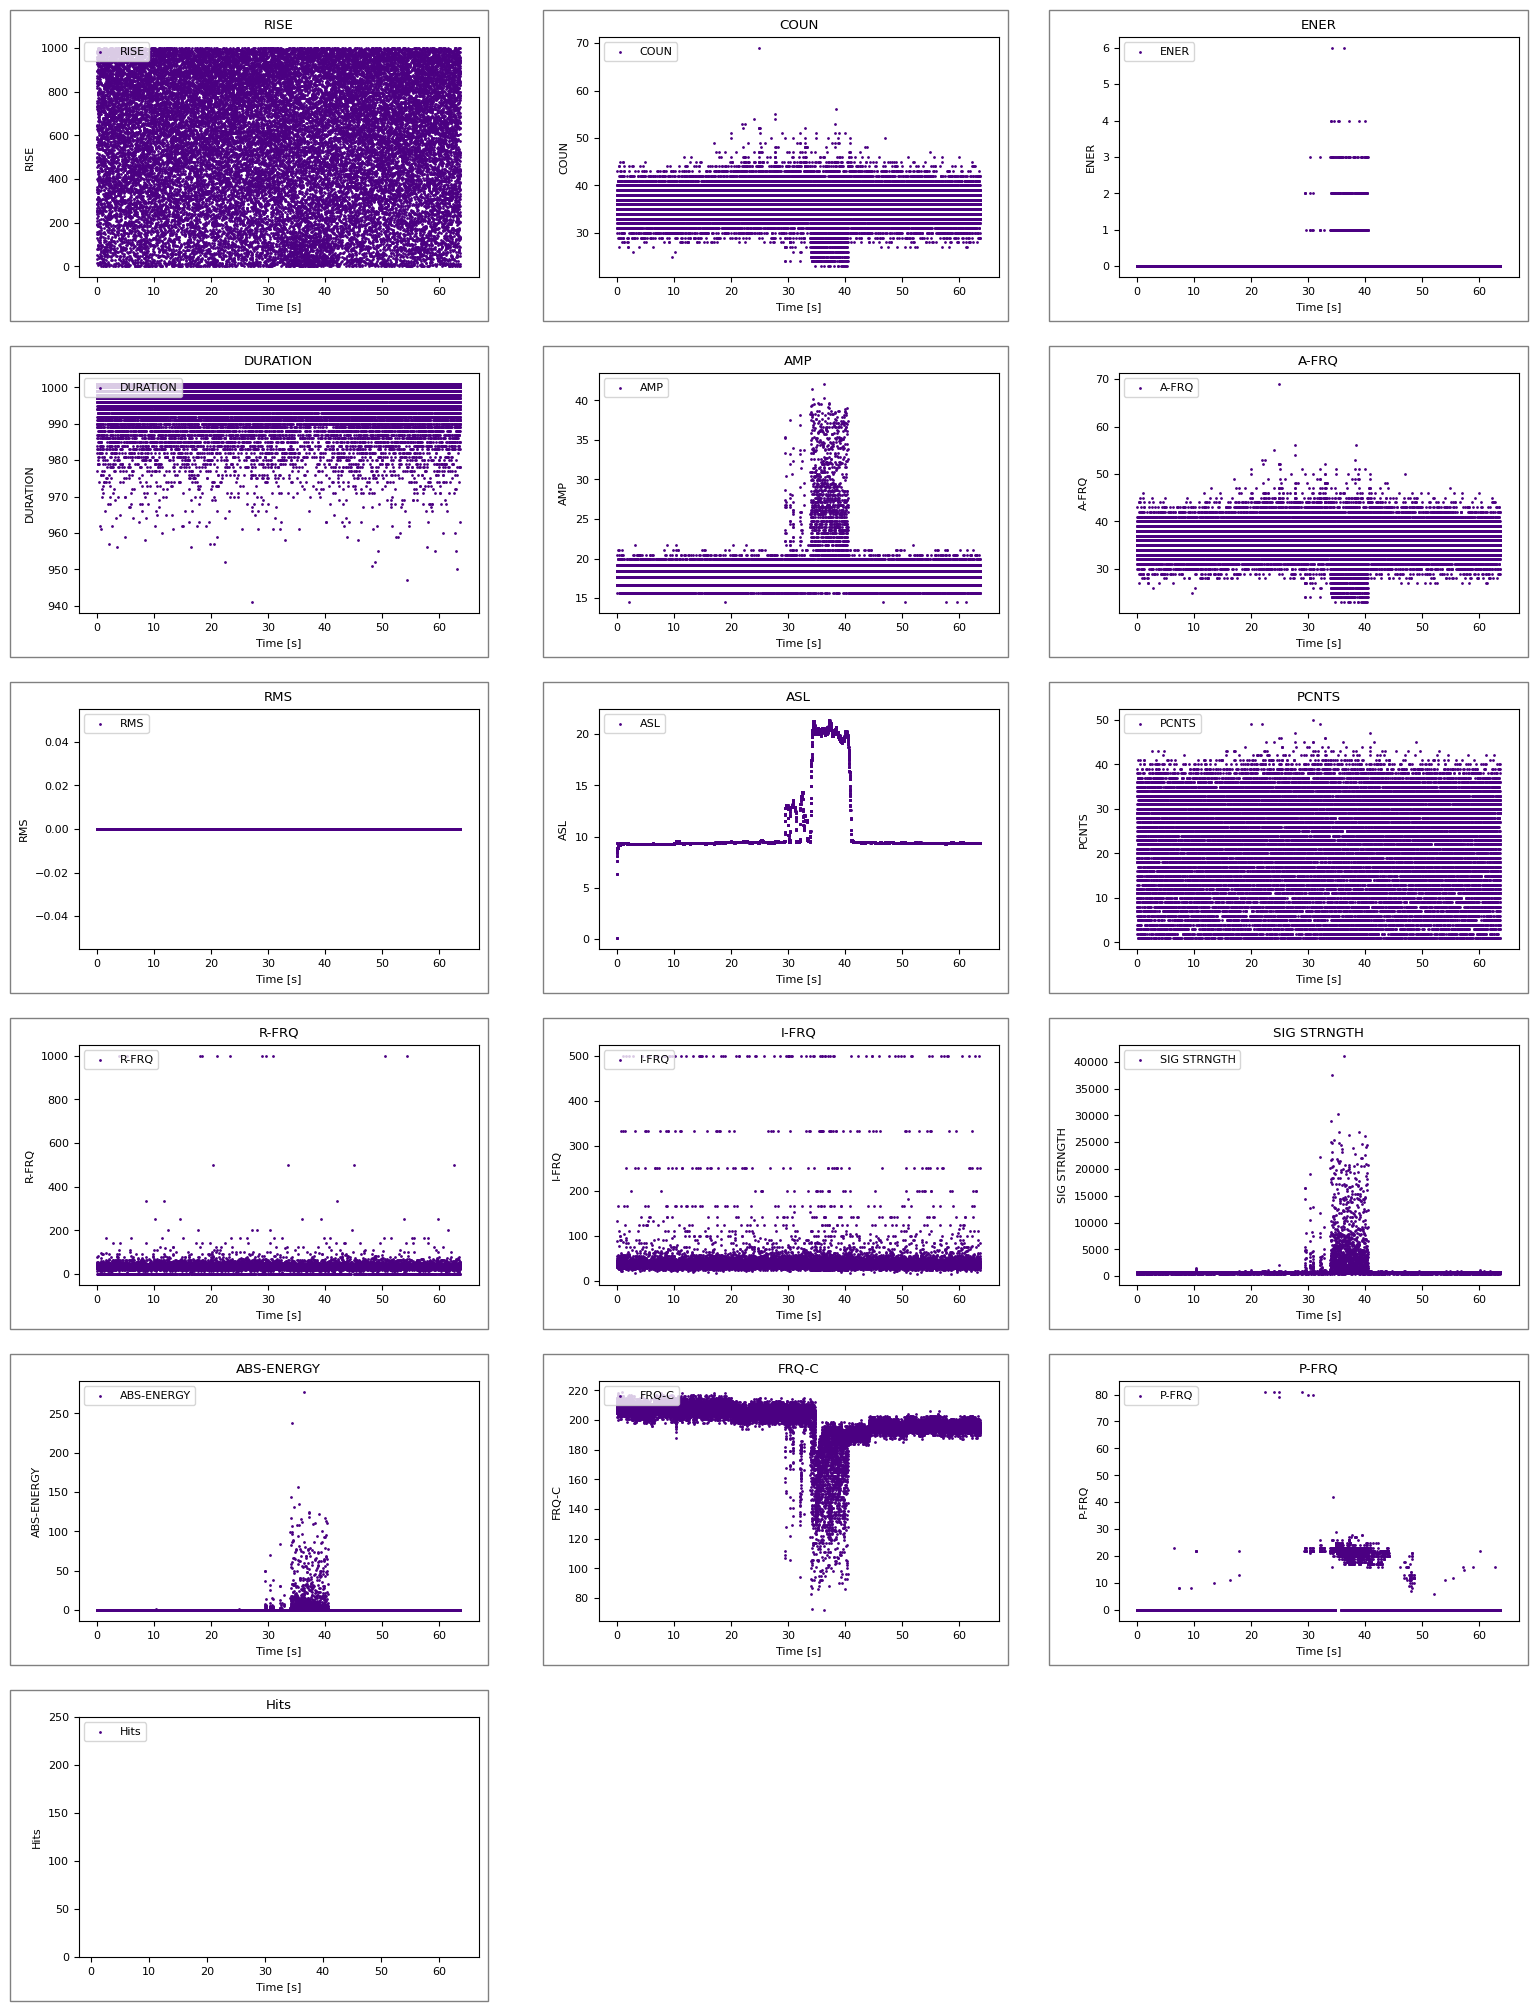

In [71]:
def plot_AE_features(mistras_df, AE_features_to_plot, trigger_delay=1.0, time_range=None, two_phase_spans=None):
    """
    Plot AE features with optional time range filtering and bordered axes groups
    
    Parameters:
        mistras_df (pd.DataFrame): DataFrame containing the AE data
        AE_features_to_plot (list): List of features to plot
        trigger_delay (float): Trigger delay value
        time_range (tuple): Optional (start_time, end_time) in seconds. If None, plots all data
        two_phase_spans (list): Optional list of two-phase span tuples
    """
    num_subplots = len(AE_features_to_plot)
    columns = 3
    rows = math.ceil(num_subplots / columns)
    mpl.rcParams['font.size'] = 8

    # Create a figure with a specified size
    fig = plt.figure(figsize=(18, rows * 4))
    
    # Create a GridSpec with specified height and width ratios
    gs = gridspec.GridSpec(rows, columns, 
                          height_ratios=[1]*rows, 
                          width_ratios=[1]*columns)
    
    # Enable interactive mode for getting renderer
    plt.ion()
    
    # Filter data based on time_range if provided
    plot_df = mistras_df
    if time_range is not None:
        start_time, end_time = time_range
        plot_df = mistras_df[(mistras_df['TIME'] >= start_time) & 
                            (mistras_df['TIME'] <= end_time)].copy()

    # Create subplots using the GridSpec
    axs = []
    twin_axes = []  # Store pairs of twin axes
    for r in range(rows):
        for c in range(columns):
            if len(axs) < num_subplots:
                axs.append(fig.add_subplot(gs[r, c]))
                twin_axes.append([None, None])  # Initialize twin axes storage

    for i, ax in enumerate(axs):
        if i < num_subplots:        
            # Plot the AE feature
            feature_to_plot = AE_features_to_plot[i]['name']
            plot_type = AE_features_to_plot[i]['plot_type']

            if plot_type == 'scatter':
                AE_plot = ax.scatter(plot_df['TIME'], plot_df[feature_to_plot], 
                                color='indigo', label=feature_to_plot, s=1)
            elif plot_type == 'line':
                AE_plot, = ax.plot(plot_df['TIME'], plot_df[feature_to_plot], 
                                color='indigo', label=feature_to_plot)

            if feature_to_plot == 'Hits':
                ax.set_ylim([0, 250])

            ax.set_xlabel("Time [s]")
            ax.set_ylabel(feature_to_plot)
            ax.set_title(feature_to_plot)
            lines = [AE_plot]
            labels = [line.get_label() for line in lines]
            ax.legend(lines, labels, loc='upper left')

            # Set x-axis limits if time_range is provided
            if time_range is not None:
                ax.set_xlim(time_range)

            if two_phase_spans:
                for two_phase_span in two_phase_spans:
                    ax.axvspan(two_phase_span[0]-trigger_delay, 
                             two_phase_span[1]-trigger_delay, 
                             color='red', alpha=0.2)
        else:
            # Hide unused subplots
            ax.set_visible(False)

    # Set figure layout parameters
    gs.update(left=0.1, right=0.9, bottom=0.1, top=0.9, 
              wspace=0.3,  # Horizontal spacing
              hspace=0.4)  # Vertical spacing
    
    # Draw the canvas to update the layout
    fig.canvas.draw()
    
    # Get renderer
    renderer = fig.canvas.get_renderer()
    
    # First pass: collect all bounding box dimensions
    bbox_dims = []  # Store dimensions for each subplot
    for i, ax in enumerate(axs):
        if i < num_subplots:
            # Get bounding box for subplot
            bbox1 = ax.get_tightbbox(renderer)
            
            # Transform to figure coordinates
            bbox_fig = bbox1.transformed(fig.transFigure.inverted())
            bbox_dims.append((i, bbox_fig.bounds))
    
    # Calculate maximum dimensions for each column
    col_widths = [0] * columns
    col_lefts = [float('inf')] * columns
    row_heights = [0] * rows
    
    for i, (x0, y0, width, height) in bbox_dims:
        col = i % columns
        row = i // columns
        col_widths[col] = max(col_widths[col], width)
        col_lefts[col] = min(col_lefts[col], x0)
        row_heights[row] = max(row_heights[row], height)
    
    # Add borders using consistent dimensions
    for i, (orig_x0, orig_y0, _, _) in bbox_dims:
        if i < num_subplots:
            col = i % columns
            row = i // columns
            
            # Use consistent dimensions for the column
            x0 = col_lefts[col]
            width = col_widths[col]
            height = row_heights[row]
            
            # Add padding
            xpad = 0.02 * width
            ypad = 0.03 * height
            
            # Add rectangle with consistent dimensions
            rect = plt.Rectangle((x0-xpad, orig_y0-ypad), 
                               width+2*xpad, height+2*ypad,
                               edgecolor='gray', 
                               linewidth=1, 
                               fill=False,
                               transform=fig.transFigure)
            fig.add_artist(rect)
    
    plt.show()

# Plot all data (default behavior)
plot_AE_features(
    mistras_df, 
    AE_features_to_plot, 
    # time_range=(0, 40),
)

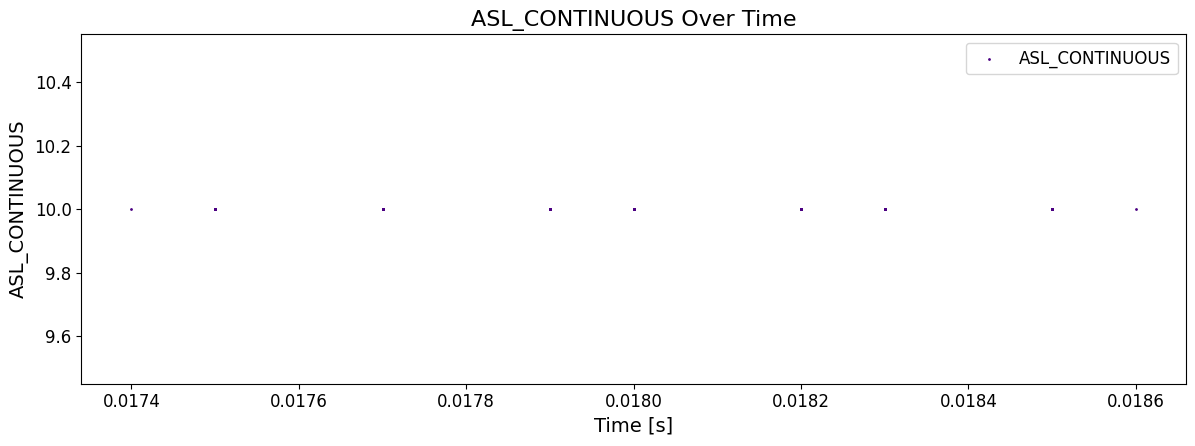

In [72]:
fig, ax1 = plt.subplots(figsize=(12,4.5))  # Increased figure size for better visibility

# feature_name = 'RMS_CONTINUOUS'
feature_name = 'ASL_CONTINUOUS'

feature = ax1.scatter(mistras_tdd_df['TIME'], mistras_tdd_df[feature_name], color='indigo', label=feature_name, s=1)

# ax1.set_xlim((0,1100))
# ax1.set_ylim((0, 50))

# Increase font sizes
ax1.set_xlabel('Time [s]', fontsize=14)
ax1.set_ylabel(feature_name, fontsize=14)

# Increase tick label font size
ax1.tick_params(axis='both', which='major', labelsize=12)

# Legend and layout adjustments
lines = [feature]
labels = [feature_name]
ax1.legend(lines, labels, loc='best', fontsize=12)

plt.title(f'{feature_name} Over Time', fontsize=16)
plt.tight_layout()
plt.show()